# Artificial Neural Networks and Deep Learning - Homework 1

<h3>Useful links</h3>

- [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)
- [keras_tuner](https://www.tensorflow.org/tutorials/keras/keras_tuner)
- [bayesian-optimization-in-cnn](https://www.kaggle.com/code/toniesteves/bayesian-optimization-in-cnn)
- [hyperparameter-search-with-bayesian-optimization-for-keras-cnn-classification-and-ensembling](https://machinelearningapplied.com/hyperparameter-search-with-bayesian-optimization-for-keras-cnn-classification-and-ensembling)
-[NN-SVG](https://alexlenail.me/NN-SVG)
- [tuning_playbook#contributing](https://github.com/google-research/tuning_playbook#contributing)


| Overfitters del test set    | PoliMi ID |
|:----------------------------|:---------:|
|Pertino Paolo                | 10729600  |
|Sandri Alberto               | 10698469  |
|Simionato Enrico             | 10698193  |

In the first homework of the Artificial Neural Networks and Deep Learning course, a binary image classification task is proposed. The goal is to understand from images of plants whether they are healthy or not.

## Table of contents

- [0. Preliminary operations](#0-preliminary-operations)
    - [0.1 Connect to drive](#01-connect-to-drive)
    - [0.2 Download and import libraries](#02-download-and-import-libraries)
- [1. Dataset inspection](#1-dataset-inspection)
    - [1.1 Loading the data](#11-loading-the-data)
    - [1.2 Outliers removal](#12-outliers-removal)

## 0. Preliminary operations

In the following section some preliminary operations in order to setup the environment correctly are performed.

### 0.1 Connect to Drive

In [1]:
try:
    from google.colab import drive
    print("Code running on Google Colab... Conncecting to Google Drive...")
    drive.mount('/gdrive')
    %cd /gdrive/My Drive/[2023-2024] AN2DL/Homework 1
except:
    print("The code is not running on Google Colab...")

Code running on Google Colab... Conncecting to Google Drive...
Mounted at /gdrive
/gdrive/My Drive/[2023-2024] AN2DL/Homework 1


### 0.2 Download and import Libraries

In [ ]:
!pip install numpy
!pip install matplotlib
!pip install keras
!pip install tqdm
!pip install scikit-learn
!pip install tensorflow[and-cuda]
!pip install shap
!pip install pandas
!pip install scipy
!pip install Cython
!pip install opencv-python

In [2]:
# Fix randomness and hide warnings
seed = 42

import os
import warnings
import logging
import random
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

random.seed(seed)

import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
#import shap
import cv2
np.random.seed(seed)

from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.applications.mobilenet import preprocess_input
from tqdm import tqdm
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from IPython.display import Image
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)
print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")

2.14.0
Num GPUs Available: 1


## 1. Dataset inspection

In this section the content of the dataset is inspected and the images are prepared for later analysis.

### 1.1 Loading the data

In [ ]:
data = np.load('data/public_data.npz', allow_pickle=True)

images = data.get('data')
labels = data.get('labels')

images.shape, labels.shape

((5200, 96, 96, 3), (5200,))

As we can see, the dataset is composed by `5200` colored images of size `96x96`.

In [ ]:
images_normalized = (images / 255).astype(np.float32)

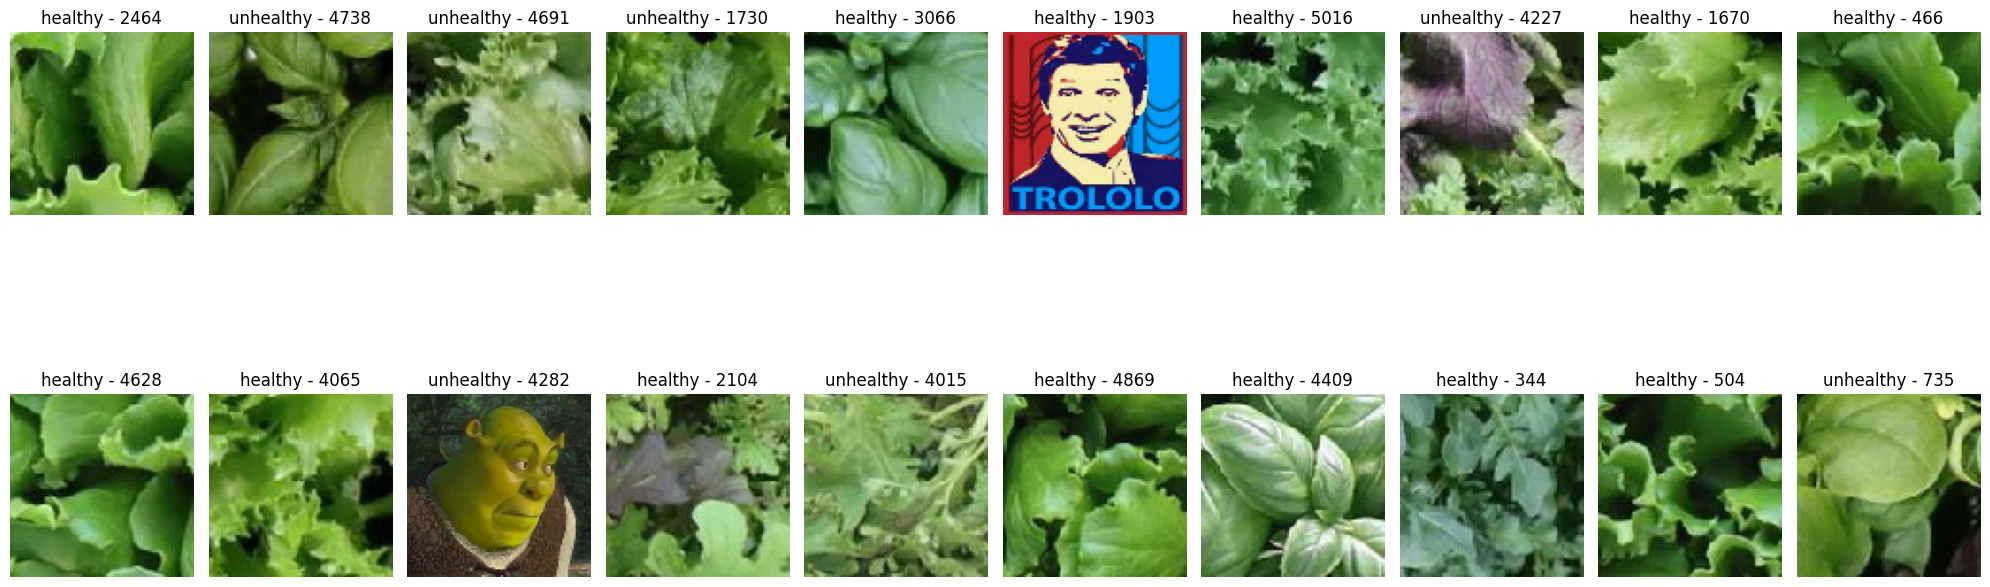

In [ ]:
# Number of images to display
num_img = 20

# Create subplots for displaying items
np.random.seed(312)
fig, axes = plt.subplots(2, num_img // 2, figsize=(20, 9))
for i in range(num_img):
    ax = axes[i % 2, i % num_img // 2]
    index_shown = np.random.randint(0, len(images))
    ax.imshow(np.clip(images_normalized[index_shown], 0, 255))  # Display clipped item images
    ax.axis('off')
    ax.set_title(f"{labels[index_shown]} - {index_shown}")
plt.tight_layout()
plt.show()

Hey! There are some outliers here! Images with index `4282` and `1903` are not plants :(

### 1.2 Outliers removal

Let's remove the outliers we have just found and all their copies in the dataset (if any).

In [ ]:
trololo = images[1903]
shrek = images[4282]

trolls = []
for i in tqdm(range(len(images))):
  if np.array_equiv(images[i], trololo) or np.array_equiv(images[i], shrek):
    trolls.append(i)

print(f"In the dataset there are {len(trolls)} outliers.")

100%|██████████| 5200/5200 [00:00<00:00, 23449.53it/s]

In the dataset there are 196 outliers.


In [ ]:
# Deleting the trolls
images_no_outliers = np.delete(images, trolls, axis = 0)
labels_no_outliers = np.delete(labels, trolls, axis = 0)

images_no_outliers.shape, labels_no_outliers.shape

((5004, 96, 96, 3), (5004,))

### 1.3 Storing and loading the dataset without outliers

In [ ]:
# Storing the dataset without outliers
np.save('data/public_data_no_outliers', images_no_outliers, allow_pickle=True)
np.save('data/public_labels_no_outliers', labels_no_outliers, allow_pickle=True)

In [3]:
images_no_outliers = np.load('data/public_data_no_outliers.npy', allow_pickle=True)
labels_no_outliers = np.load('data/public_labels_no_outliers.npy', allow_pickle=True)

images_no_outliers.shape, labels_no_outliers.shape

((5004, 96, 96, 3), (5004,))

### 1.4 Plots and statistics

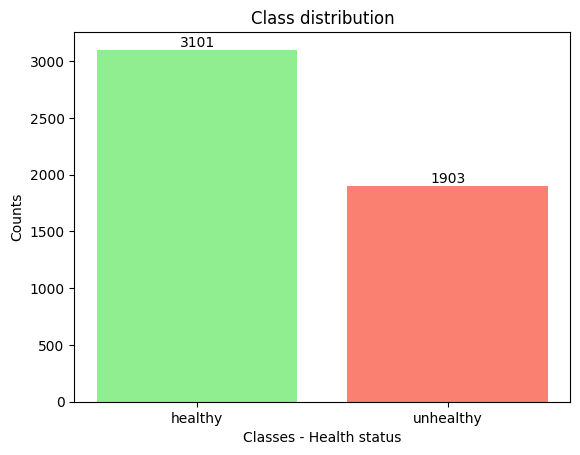

In [ ]:
# Defining the counts
counts = [sum(labels_no_outliers=='healthy'), sum(labels_no_outliers=='unhealthy')]

# Define labels
labels = ['healthy', 'unhealthy']

# Define colors for the bars
colors = ['lightgreen', 'salmon']

# Create the barplot
plt.bar(labels, counts, color=colors)

# Add axes labels
plt.xlabel('Classes - Health status')
plt.ylabel('Counts')

# Add title
plt.title('Class distribution')

# Add counts on top of the bars
for i, value in enumerate(counts):
  plt.text(labels[i], value, str(value), ha='center', va='bottom')

# Plot
plt.show()

In [ ]:
print(f"""
  In the healthy class there are {counts[0]} samples which cover the {(counts[0] / (counts[0] + counts[1]))*100:.2f}% of the whole dataset.
  In the unhealthy class there are {counts[1]} samples which cover the {(counts[1] / (counts[0] + counts[1]))*100:.2f}% of the whole dataset.
""")


  In the healthy class there are 3101 samples which cover the 61.97% of the whole dataset. 
  In the unhealthy class there are 1903 samples which cover the 38.03% of the whole dataset.



The dataset is a little bit unbalanced towards the healthy class since there are 3101 samples in this class against 1903 of the other. However we think that this is not a big problem since the difference is not so big.

### 1.5 Pre-processing (2 classes)

In [42]:
# Convert labels to one-hot encoding format
y = np.zeros((labels_no_outliers.shape[0], 2))
y[labels_no_outliers=='healthy', 0] = 1.
y[labels_no_outliers=='unhealthy', 1] = 1.

# Setting the input dataset to split
X = (images_no_outliers / 255).astype(np.float32)

# Defining the number of samples in the test set and in the validation set
validation_size = 750
test_size = 750

# Split data into train_val and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=seed, test_size=test_size, stratify=np.argmax(y,axis=1))

# Further split train_val into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=validation_size, stratify=np.argmax(y_train_val,axis=1))

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (3504, 96, 96, 3), y_train shape: (3504, 2)
X_val shape: (750, 96, 96, 3), y_val shape: (750, 2)
X_test shape: (750, 96, 96, 3), y_test shape: (750, 2)


### 1.5.1 Pre-processing (1 class)

In [ ]:
# Convert labels to one-hot encoding format
y = np.zeros((labels_no_outliers.shape[0],))
y[labels_no_outliers=='healthy'] = 0.
y[labels_no_outliers=='unhealthy'] = 1.

# Setting the input dataset to split
X = (images_no_outliers / 255).astype(np.float32)

# Defining the number of samples in the test set and in the validation set
validation_size = 750  # 15%
test_size = 750  # 15%

# Split data into train_val and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=seed, test_size=test_size, stratify=y)

# Further split train_val into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=validation_size, stratify=y_train_val)

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

### 1.6 Mixup Augmentation

In [ ]:
def mixup_images_labels(images : np.ndarray, labels : np.ndarray, alpha : float = 0.2, seed : int = 42):
    """
    Mixup augmentation for a dataset of images and labels.

    Parameters:
        images (numpy.ndarray): An array of images with shape (num_images, height, width, channels).
        labels (numpy.ndarray): An array of one-hot encoded labels with shape (num_images, num_classes).
        alpha (float): Mixup hyperparameter, controls the interpolation ratio.

    Returns:
        mixed_images (numpy.ndarray): Mixed images.
        mixed_labels (numpy.ndarray): Mixed labels.
    """
    num_images = images.shape[0]

    # Shuffle the dataset to ensure random mixing
    np.random.seed(seed)
    permutation = np.random.permutation(num_images)
    shuffled_images = images[permutation]
    shuffled_labels = labels[permutation]

    lam = np.random.beta(alpha, alpha, num_images)
    mixed_images = lam[:, np.newaxis, np.newaxis, np.newaxis] * images + (1 - lam[:, np.newaxis, np.newaxis, np.newaxis]) * shuffled_images
    mixed_labels = lam[:, np.newaxis] * labels + (1 - lam[:, np.newaxis]) * shuffled_labels

    return mixed_images, mixed_labels

X_train_mixup, y_train_mixup = mixup_images_labels(X_train, y_train, 0.15)

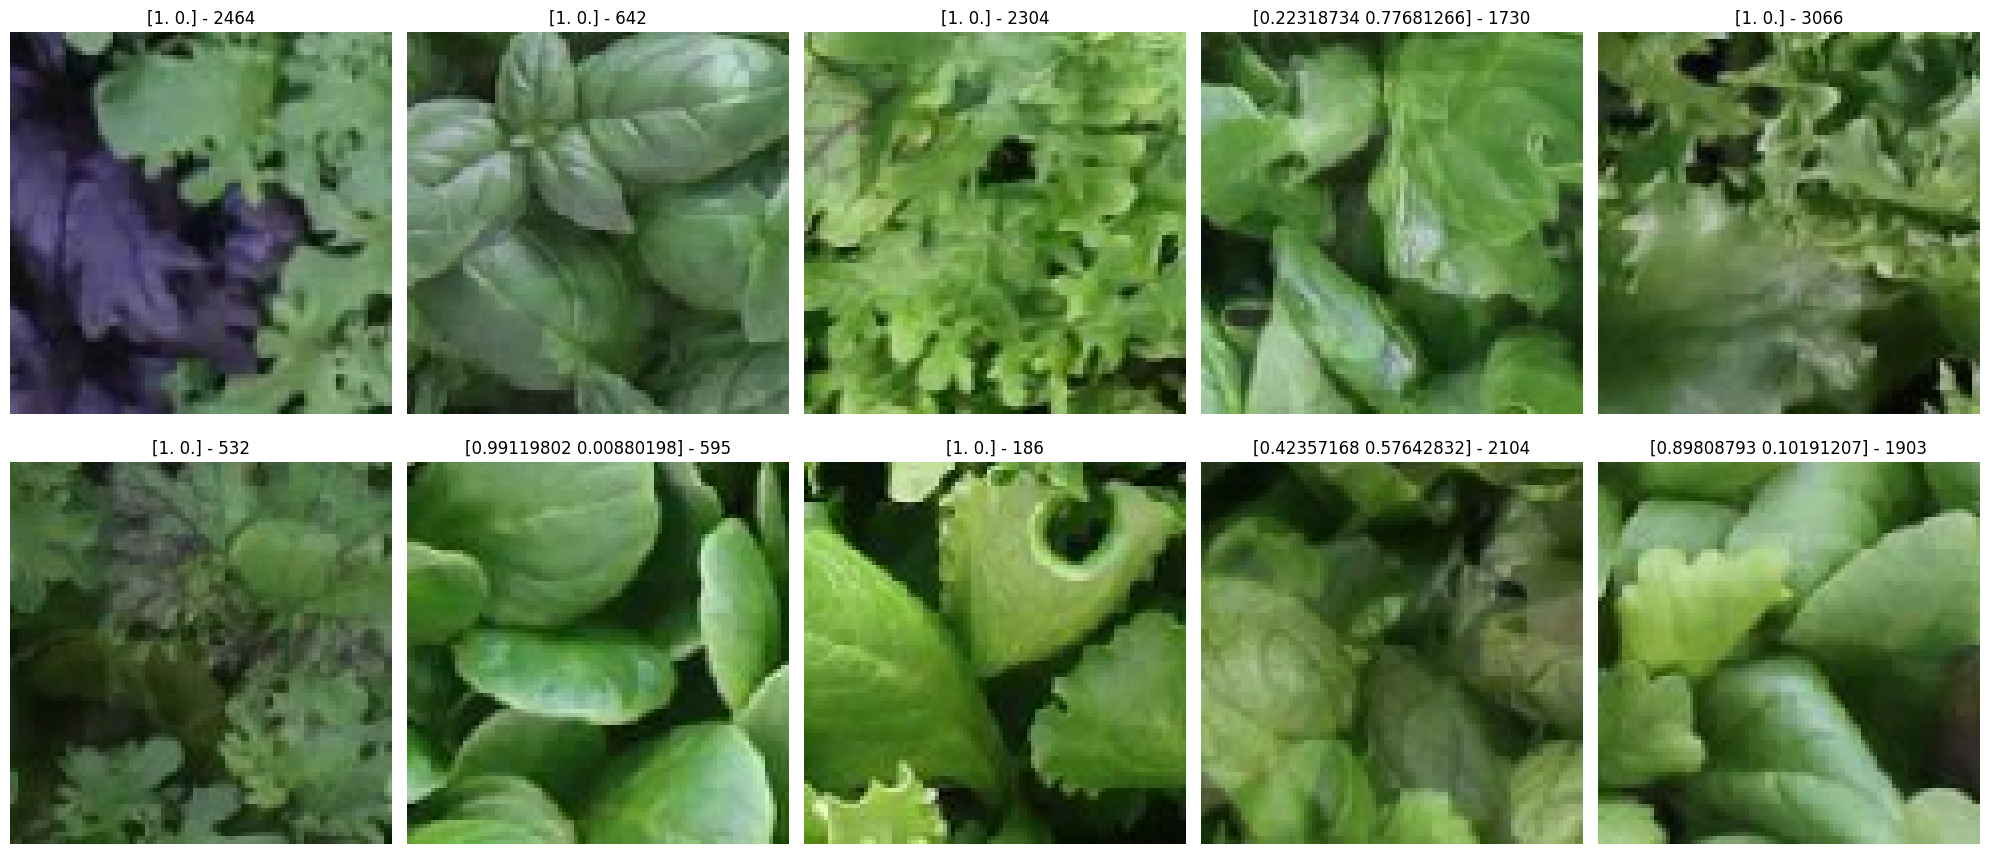

In [ ]:
# Number of images to display
num_img = 10

# Create subplots for displaying items
np.random.seed(312)
fig, axes = plt.subplots(2, num_img // 2, figsize=(20, 9))
for i in range(num_img):
    ax = axes[i % 2, i % num_img // 2]
    index_shown = np.random.randint(0, len(X_train_mixup))
    ax.imshow(np.clip(X_train_mixup[index_shown], 0, 255))  # Display clipped item images
    ax.axis('off')
    ax.set_title(f"{y_train_mixup[index_shown]} - {index_shown}")
plt.tight_layout()
plt.show()

## 2. Models

### 2.1 Utility functions

In [25]:
def plot_confusion_matrix(preprocessed_input : np.ndarray, y_test : np.ndarray, threshold : int = 0.5, model_to_test : tf.keras.Model = None, model_name : str = None, one_class : bool = False) -> None:
  '''
    Plots the confusion matrix and displays classification metrics for the
    specified model on the specified test data.

    The function first checks whether a model or a model name is provided for
    evaluation. If neither is provided, it will print an error message and
    return without further execution.

    If a model is provided (model_to_test is not None), the function uses it for
    evaluation. If only a model name is provided, the function loads the saved
    model with that name using tf.keras.models.load_model.

    It then predicts labels for the test data using the model and calculates
    the confusion matrix, as well as various classification metrics, including
    accuracy, precision, recall, and F1-score.

    The confusion matrix is plotted using a heatmap, and the classification
    metrics are displayed in the console.

    Parameters:
      preprocessed_input (numpy.ndarray): Preprocessed input data for testing.
      y_test (numpy.ndarray): Ground truth labels for the test data.
      model_to_test (tf.keras.Model, optional): The model to evaluate. If
      provided, this model will be used for evaluation.
      model_name (str, optional): The name of a saved Keras model to load for
      evaluation. If provided, this model will be loaded and used for
      evaluation.
      one_class (bool, optional): If True the output has one neuron. By default
      output has two neurons.

    Returns:
      None
  '''

  if model_to_test is None and model_name is None:
    print("You have to specify either a model name or pass directly the model you want to evaluate.")
    return

  if model_to_test is not None:
    # Loading the model
    model = model_to_test
  else:
    model = tf.keras.models.load_model(model_name)

  # Predict labels for the entire test set
  predictions_logits = model.predict(preprocessed_input, verbose=0)

  if one_class:
    predicted_label = np.array([1. if prediction >= threshold else 0. for prediction in predictions_logits])
    true_label = y_test
  else:
    predictions = np.array([[1., 0.] if sublist[0] >= threshold else [0., 1.] for sublist in predictions_logits])
    true_label = np.argmax(y_test, axis=-1)
    predicted_label = np.argmax(predictions, axis=-1)

  # Compute the confusion
  cm = confusion_matrix(true_label, predicted_label)

  # Compute classification metrics
  accuracy = accuracy_score(true_label, predicted_label)
  precision = precision_score(true_label, predicted_label)
  recall = recall_score(true_label, predicted_label)
  f1 = f1_score(true_label, predicted_label)

  # Display the computed metrics
  print('Accuracy:', accuracy.round(4))
  print('Precision:', precision.round(4))
  print('Recall:', recall.round(4))
  print('F1:', f1.round(4))

  # Plot the confusion matrix
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm.T, xticklabels=list(('healthy','unhealthy')), yticklabels=list(('healthy','unhealthy')), cmap='Blues', annot=True)
  plt.xlabel('True labels')
  plt.ylabel('Predicted labels')
  plt.show()

  if model_name:
    del model

In [ ]:
def plot_roc_curve(model : tf.keras.Model, X : np.ndarray, y : np.ndarray, plot_diagrams : bool = True) -> float:
  '''
    Plots Receiver Operating Characteristic (ROC) curves for different threshold
    values and identifies the best threshold based on the highest AUC score.

    This function calculates and plots ROC curves for a given model's predictions
    on the input data, considering various threshold values (from 0.05 to 1 with
    step 0.05). It also identifies the best threshold based on the highest Area
    Under the Curve (AUC) score.

    Parameters:
        model (tf.keras.Model): The machine learning model for which the ROC
                                curves are plotted.
        X (numpy.ndarray): Input data used for model predictions.
        y (numpy.ndarray): Ground truth labels for the input data.

    Returns:
        float: the best threshold retrieved by the aalysis of the AUC score.

  '''

  roc_curves = []
  predictions_logits = model.predict(X)

  thresholds = np.arange(0.05, 1.05, 0.05)
  best_auc = 0
  best_threshold = 0

  for threshold in thresholds:
      # Convert predictions using the current threshold
      predictions = np.array([[1., 0.] if sublist[0] >= threshold else [0., 1.] for sublist in predictions_logits])

      # Calculate the ROC curve
      fpr, tpr, _ = roc_curve(y.argmax(axis=-1), predictions.argmax(axis=-1))

      roc_auc = auc(fpr, tpr)
      # Append the ROC curve data to the list
      roc_curves.append((fpr, tpr, threshold))

      if roc_auc > best_auc:
        best_auc = roc_auc
        best_threshold = threshold

  # Plot ROC curves
  if plot_diagrams:
    plt.figure(figsize=(8, 6))
    for fpr, tpr, threshold in roc_curves:
        plt.plot(fpr, tpr, label=f'Threshold: {threshold}')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Plot the diagonal line for reference
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC Curve')
    plt.legend(loc='best')
    plt.show()
    print(f"The best threshold is {best_threshold} with AUC score of {best_auc}")
  return best_threshold

In [13]:
def plot_training(history):
  '''
    Plots training and validation performance metrics, including loss and
    accuracy, and highlights the epoch with the highest validation accuracy.

    This function takes a history dictionary that contains training and
    validation metrics recorded during model training and visualizes the
    training and validation performance over epochs. It also highlights
    the epoch with the highest validation accuracy.

    Parameters:
        history (dict): A dictionary containing training and validation metrics
        (e.g., loss, accuracy) recorded during model training.

    Returns:
        None
  '''

  # Find the epoch with the highest validation accuracy
  best_epoch = np.argmax(history['val_accuracy'])

  # Plot training and validation performance metrics
  plt.figure(figsize=(20, 5))

  # Plot training and validation loss
  plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
  plt.plot(history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
  plt.legend(loc='upper left')
  plt.title('Binary Crossentropy')
  plt.grid(alpha=0.3)

  plt.figure(figsize=(20, 5))

  # Plot training and validation accuracy, highlighting the best epoch
  plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
  plt.plot(history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
  plt.plot(best_epoch, history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
  plt.legend(loc='upper left')
  plt.title('Accuracy')
  plt.grid(alpha=0.3)

  plt.show()

In [ ]:
def k_fold_cross_validation(
    train_data : np.ndarray,
    train_labels : np.ndarray,
    model_builder,
    model_builder_parameters : tuple = (),
    early_stopping_patience : int = 0,
    epochs : int = 200,
    batch_size : int = 32,
    model_callbacks : list = None,
    num_folds : int = 5,
    verbose = 0,
    seed : int = 42
  ) -> dict:
  '''
  Perform K-fold cross-validation for training and evaluating the specified
  model class.

  This function performs K-fold cross-validation by splitting the training
  data into multiple folds, training a model on each fold, and evaluating its
  performance on the validation data. It returns a dictionary with information
  about the training process for each fold.

  Parameters:
      train_data (numpy.ndarray): The training data used for cross-validation.
      train_labels (numpy.ndarray): The corresponding ground truth labels for the training data.
      model_builder (function): A function that builds and returns the model class of interest. This function should take model parameters as input.
      model_builder_parameters (tuple, optional): Additional parameters to be passed to the model_builder function.
      early_stopping_patience (int, optional): The number of epochs to wait for improvement during early stopping. Set this number equal to the one you have chosen for the early stopping.
      epochs (int, optional): The maximum number of epochs for training each fold.
      model_callbacks (list, optional): List of Keras callbacks to be applied during training.
      num_folds (int, optional): The number of cross-validation folds.
      seed (int, optional): Random seed for controlling the randomness of cross-validation.

  Returns:
      dict: A dictionary containing the training histories, validation scores, best epochs for early stopping, and best prediction thresholds for each fold.

  '''

  # Initialize lists to store training histories, scores, and best epochs
  result = {}
  histories = []
  scores = []
  best_epochs = []
  best_prediction_thresholds = []

  # Create a KFold cross-validation object
  kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)

  # Loop through each fold
  for fold_idx, (train_idx, valid_idx) in enumerate(kfold.split(train_data, train_labels)):

    print(f"Starting training on fold num: {fold_idx+1}")

    # Build a new dropout model for each fold
    k_model = model_builder(*model_builder_parameters)

    # Train the model on the training data for this fold
    history = k_model.fit(
      x = X_train_val[train_idx],
      y = y_train_val[train_idx],
      validation_data=(X_train_val[valid_idx], y_train_val[valid_idx]),
      batch_size = batch_size,
      epochs = epochs,
      callbacks = model_callbacks,
      verbose = verbose
    ).history

    # Evaluate the model on the validation data for this fold
    score = k_model.evaluate(X_train_val[valid_idx], y_train_val[valid_idx], verbose=0)
    scores.append(score[1])

    # Calculate the best epoch for early stopping
    best_epoch = len(history['loss']) - early_stopping_patience
    best_epochs.append(best_epoch)

    # Store the training history for this fold
    histories.append(history)

    # Store the best prediction threshold
    best_prediction_thresholds.append(
        plot_roc_curve(
            k_model,
            X_train_val[valid_idx],
            y_train_val[valid_idx],
            plot_diagrams = False)
    )

  result.update({
      'histories' : histories,
      'scores' : scores,
      'best_epochs' : best_epochs,
      'best_thresholds' : best_prediction_thresholds
  })

  return result

In [57]:
def undersample(X : np.ndarray, y : np.ndarray, one_class : bool = False) -> tuple:
  '''
    Perform undersampling on the given data.

    Parameters:
      X (numpy.ndarray): Preprocessed input data for training.
      y (numpy.ndarray): Ground truth labels for the train data.
      one_class (bool, optional): If True the output has one neuron. By default
      output has two neurons.

    Returns:
      tuple: A tuple containing the given X and y undersampled.
  '''

  reshaped_X = X.reshape(X.shape[0],-1)

  if not one_class:
    y = np.argmax(y, axis=-1)

  undersample = RandomUnderSampler()
  undersampled_X, undersampled_y  = undersample.fit_resample(reshaped_X , y)

  if not one_class:
    undersampled_y = np.array([[1., 0.] if sample == 0. else [0., 1.] for sample in undersampled_y])

  return undersampled_X.reshape(-1,96,96,3), undersampled_y

In [30]:
def oversample(X : np.ndarray, y : np.ndarray, one_class : bool = False) -> tuple:
  '''
    Perform oversampling on the given data.

    Parameters:
      X (numpy.ndarray): Preprocessed input data for training.
      y (numpy.ndarray): Ground truth labels for the train data.
      one_class (bool, optional): If True the output has one neuron. By default
      output has two neurons.

    Returns:
      tuple: A tuple containing the given X and y overrsampled.
  '''

  reshaped_X = X.reshape(X.shape[0],-1)

  if not one_class:
    y = np.argmax(y, axis=-1)

  oversample = RandomOverSampler()
  oversampled_X, oversampled_y  = oversample.fit_resample(reshaped_X , y)

  if not one_class:
    oversampled_y = np.array([[1., 0.] if sample == 0. else [0., 1.] for sample in oversampled_y])

  return oversampled_X.reshape(-1,96,96,3), oversampled_y

### 2.2 Custom Baseline

In [ ]:
def build_custom_baseline(input_shape, output_shape, seed=seed):
  tf.random.set_seed(seed) # Execution on GPUs loses the deterministic execution guaranteed by the seed

  # Build the neural network layer by layer
  input_layer = tfkl.Input(shape=input_shape, name='Input')

  # Convolutional layers are linear layers
  conv1 = tfkl.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='swish', name='conv1')(input_layer)

  #conv1_1 = tfkl.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='swish', name='conv1_1')(conv1)

  pool1 = tfkl.MaxPooling2D(pool_size=(2,2), name='mp1')(conv1)

  conv2 = tfkl.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='swish', name='conv2')(pool1)

  #conv2_1 = tfkl.Conv2D(filters=32,kernel_size=(3,3), padding='same',activation='swish', name='conv2_1')(conv2)

  pool2 = tfkl.MaxPooling2D(pool_size =(2,2), name='mp2')(conv2)

  conv3 = tfkl.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='swish', name='conv3')(pool2)

  #conv3_1 = tfkl.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='swish', name='conv3_1')(conv3)

  #pool3 = tfkl.MaxPooling2D(pool_size=(2,2), name='mp3')(conv3)

  #conv4 = tfkl.Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='swish', name='conv4')(pool3)

  #conv4_1 = tfkl.Conv2D(filters=128, kernel_size=(3,3),padding='same',activation='swish', name='conv4_1')(conv4)

  gap = tfkl.GlobalAveragePooling2D(name='gap')(conv3)

  classifier_layer1 = tfkl.Dense(
      units=120,
      activation='swish',
      name='dense1'
  )(gap)

  classifier_layer2 = tfkl.Dense(
      units=84,
      activation='swish',
      name='dense2'
  )(classifier_layer1)

  output_layer = tfkl.Dense(
      units=output_shape,
      activation='softmax',
      name='Output'
  )(classifier_layer2)

  # Connect input and output through the Model class
  model = tfk.Model(inputs=input_layer, outputs=output_layer, name='custom_baseline')

  # Compile the model
  model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.AdamW(), metrics=['accuracy'])

  # Return the model
  return model

In [ ]:
input_shape = (96, 96, 3)
output_shape = 2

# Build the LeNet model and display its summary
model = build_custom_baseline(input_shape, output_shape)
model.summary()

Model: "custom_baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 96, 96, 32)        896       
                                                                 
 mp1 (MaxPooling2D)          (None, 48, 48, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 48, 48, 64)        18496     
                                                                 
 mp2 (MaxPooling2D)          (None, 24, 24, 64)        0         
                                                                 
 conv3 (Conv2D)              (None, 24, 24, 128)       73856     
                                                                 
 gap (GlobalAveragePooling2  (None, 128)           

In [ ]:
#dropout = tfkl.Dropout(dropout_rate, seed=seed)(hidden_activation)

In [ ]:
# Define the hyperparameters
batch_size = 16
epochs = 200

# Define early stopping callback
early_stopping = tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, mode='max', restore_best_weights=True)
lr_patience = 5
lr_scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',     # Metric to monitor (validation mean squared error in this case)
    patience=lr_patience,  # Number of epochs with no improvement after which learning rate will be reduced
    factor=0.999,          # Factor by which the learning rate will be reduced (0.999 in this case)
    mode='max',            # Mode to decide when to reduce learning rate ('min' means reduce when metric stops decreasing)
    min_lr=1e-5            # Minimum learning rate
)

# Train the model and save its history
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, lr_scheduler]
).history

# Save the trained model
model.save('models/custom_baseline_multiple_conv')

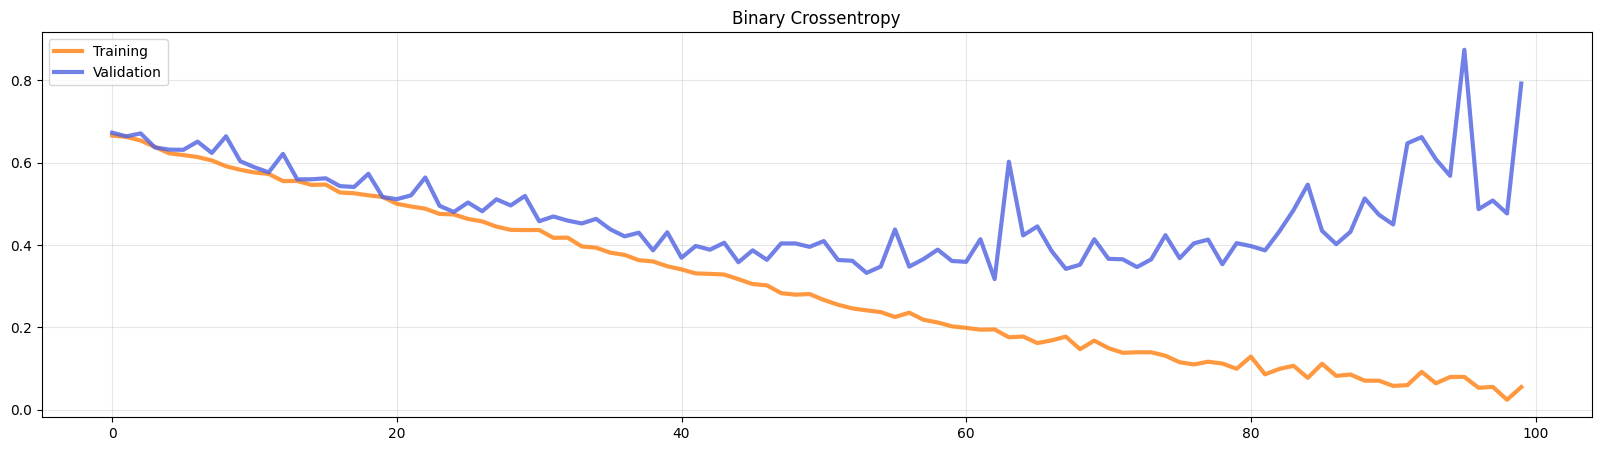

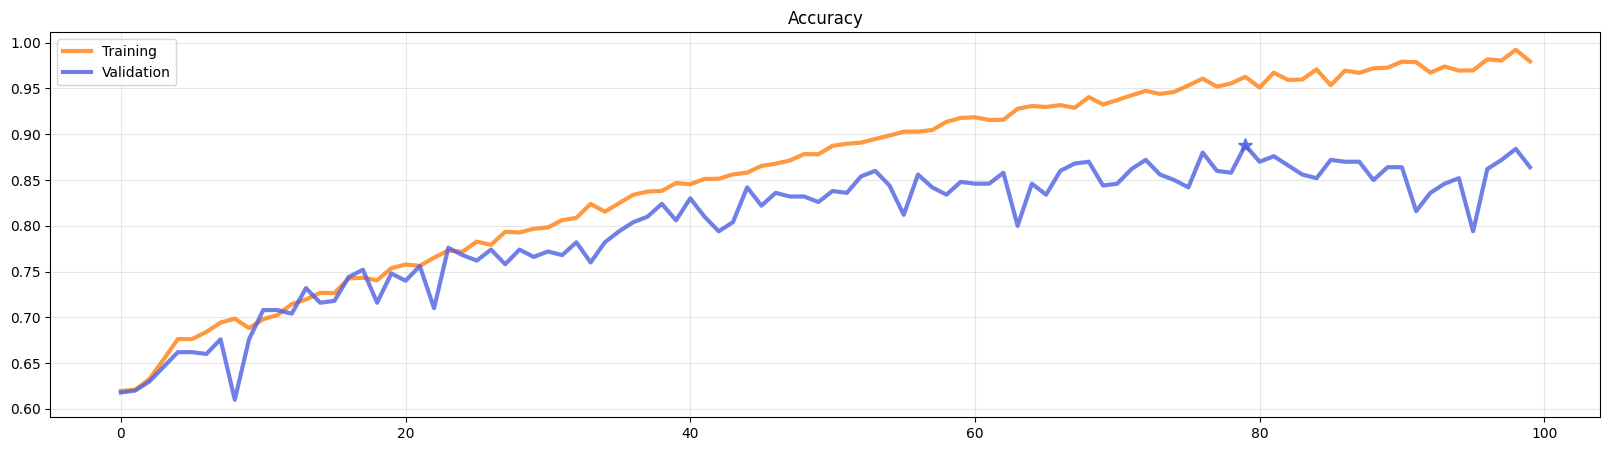

In [ ]:
# Find the epoch with the highest validation accuracy
best_epoch = np.argmax(history['val_accuracy'])

# Plot training and validation performance metrics
plt.figure(figsize=(20, 5))

# Plot training and validation loss
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=0.3)

plt.figure(figsize=(20, 5))

# Plot training and validation accuracy, highlighting the best epoch
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.plot(best_epoch, history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=0.3)

plt.show()

Predictions Shape: (500, 2)
Accuracy: 0.884
Precision: 0.8626
Recall: 0.8263
F1: 0.8441


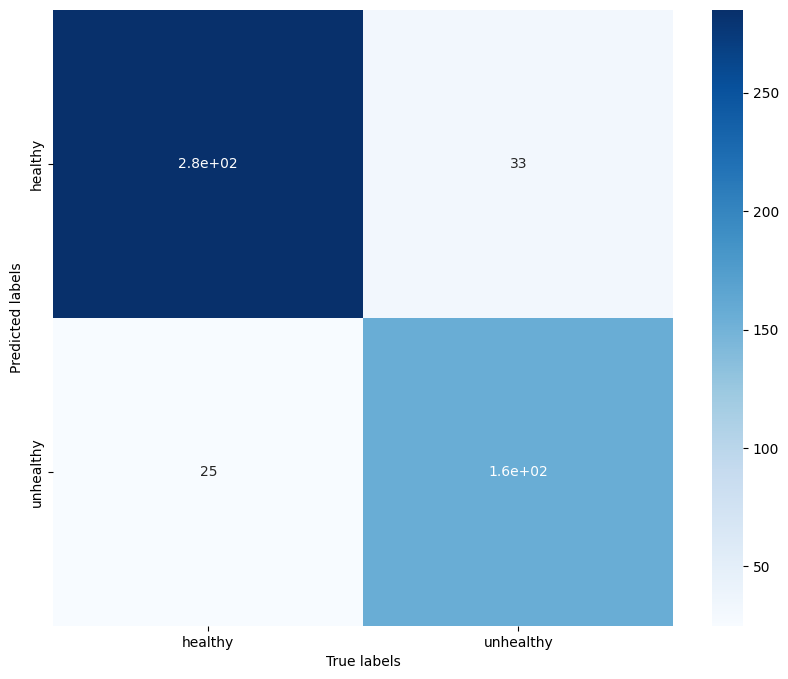

In [ ]:
plot_confusion_matrix('models/custom_baseline_multiple_conv', X_test, y_test)

#### Training again on the whole dataset

In [ ]:
# Define the test size
test_size = 100

# Split data into train_val and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size, stratify=np.argmax(y,axis=1))

In [ ]:
input_shape = (96, 96, 3)
output_shape = 2

# Build the LeNet model and display its summary
model = build_custom_baseline(input_shape, output_shape)
model.summary()

Model: "custom_baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 96, 96, 32)        896       
                                                                 
 mp1 (MaxPooling2D)          (None, 48, 48, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 48, 48, 64)        18496     
                                                                 
 mp2 (MaxPooling2D)          (None, 24, 24, 64)        0         
                                                                 
 conv3 (Conv2D)              (None, 24, 24, 128)       73856     
                                                                 
 gap (GlobalAveragePooling2  (None, 128)           

In [ ]:
# Define the hyperparameters
batch_size = 16
epochs = 200

# Define early stopping callback
early_stopping = tfk.callbacks.EarlyStopping(monitor='accuracy', patience=20, mode='max', restore_best_weights=True)

# Define learning rate scheduler callback
lr_patience = 5
lr_scheduler = tfk.callbacks.ReduceLROnPlateau(monitor='accuracy', patience=lr_patience, factor=0.999, mode='max', min_lr=1e-5)

# Train the model and save its history
history = model.fit(
    x=X,
    y=y,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[early_stopping, lr_scheduler]
).history

# Save the trained model
model.save('models/custom_baseline_multiple_conv_whole_dataset')

In [ ]:
# Save the trained model
model.save('models/custom_baseline_multiple_conv_whole_dataset')

In [ ]:
# Find the epoch with the highest validation accuracy
best_epoch = np.argmax(history['accuracy'])

# Plot training and validation performance metrics
plt.figure(figsize=(20, 5))

# Plot training and validation loss
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=0.3)

plt.figure(figsize=(20, 5))

# Plot training and validation accuracy, highlighting the best epoch
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(best_epoch, history['accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=0.3)

plt.show()

In [ ]:
plot_confusion_matrix('models/custom_baseline_multiple_conv_whole_dataset', X_test, y_test)

In [ ]:
# Find the epoch with the highest validation accuracy
best_epoch = np.argmax(history['val_accuracy'])

# Plot training and validation performance metrics
plt.figure(figsize=(20, 5))

# Plot training and validation loss
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=0.3)

plt.figure(figsize=(20, 5))

# Plot training and validation accuracy, highlighting the best epoch
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.plot(best_epoch, history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=0.3)

plt.show()

### 2.2 Paolo's models

### 2.3 Alberto's models

#### Custom model

In [ ]:
def build_custom_baseline(input_shape, output_shape, seed=seed):
  tf.random.set_seed(seed)
  dropout_rate = 1/6

  preprocessing = tfk.Sequential([
        tfkl.RandomFlip('horizontal'),
        tfkl.RandomFlip('vertical'),
        tfkl.RandomRotation(0.2),
        tfkl.RandomZoom(0.2),
    ], name='Preprocessing')

  # Build the neural network layer by layer
  input_layer = tfkl.Input(shape=input_shape, name='Input')

  preprocessing = preprocessing(input_layer)

  # Convolutional layers are linear layers
  x = tfkl.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', name='conv1')(preprocessing)
  x = tfkl.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu', name='conv1_1')(x)
  x = tfkl.BatchNormalization(name='batchNorm1')(x)
  x = tfkl.MaxPooling2D(pool_size=(2,2), name='mp1')(x)
  x = tfkl.Dropout(dropout_rate, seed=seed)(x)

  x = tfkl.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', name='conv2')(x)
  x = tfkl.Conv2D(filters=64,kernel_size=(3,3), padding='same',activation='relu', name='conv2_1')(x)
  x = tfkl.BatchNormalization(name='batchNorm2')(x)
  x = tfkl.MaxPooling2D(pool_size =(2,2), name='mp2')(x)
  x = tfkl.Dropout(dropout_rate, seed=seed)(x)

  x = tfkl.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', name='conv3')(x)
  x = tfkl.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu', name='conv3_1')(x)
  x = tfkl.BatchNormalization(name='batchNorm3')(x)
  x = tfkl.MaxPooling2D(pool_size=(2,2), name='mp3')(x)
  x = tfkl.Dropout(dropout_rate, seed=seed)(x)

  x = tfkl.Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu', name='conv4')(x)
  x = tfkl.Conv2D(filters=256, kernel_size=(3,3),padding='same',activation='relu', name='conv4_1')(x)
  x = tfkl.BatchNormalization(name='batchNorm4')(x)
  x = tfkl.GlobalAveragePooling2D(name='gap')(x)
  x = tfkl.Dropout(dropout_rate, seed=seed)(x)

  output_layer = tfkl.Dense(units=2, activation='softmax',name='Output')(x)

  #classifier_layer2 = tfkl.Dense(units=84, activation='relu', name='dense2')(classifier_layer1)
  #output_layer = tfkl.Dense(units=output_shape, activation='softmax', name='Output')(classifier_layer2)

  # Connect input and output through the Model class
  model = tfk.Model(inputs=input_layer, outputs=output_layer, name='custom_baseline')

  # Compile the model
  model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.AdamW(), metrics=['accuracy'])

  # Return the model
  return model

In [ ]:
from IPython.display import Image

image = tfk.utils.plot_model(model, show_shapes=True, expand_nested=True)

# Define the output file path
output_file = "models/custom_baseline4/model_image.png"

# Save the image to the specified file
with open(output_file, "wb") as f:
    f.write(image.data)

In [ ]:
input_shape = (96, 96, 3)
output_shape = 2

# Build the LeNet model and display its summary
model = build_custom_baseline(input_shape, output_shape)
model.summary()

In [ ]:
# Define the hyperparameters
batch_size = 16
epochs = 200

# Define callbacks
early_stopping = tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, mode='max', restore_best_weights=True)
lr_scheduler = tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=5, factor=0.999, mode='max', min_lr=1e-5)

# Train the model and save its history
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, lr_scheduler]
).history

# Save the trained model
model.save('models/custom_baseline2')

In [ ]:
plot_training(history)

In [ ]:
plot_confusion_matrix('models/custom_baseline2', X_test, y_test)

####Transfer learning

##### 2 classes

In [8]:
from tensorflow.keras.applications.efficientnet import preprocess_input

In [10]:
efficient = tf.keras.applications.EfficientNetB0(
                    include_top=False,
                    weights="imagenet",
                    input_shape=(96, 96, 3),
                    pooling='avg',
                  )
#tfk.utils.plot_model(inceptionResnet, show_shapes=True)

efficient.trainable = False

# Define the augmentation
preprocessing = tfk.Sequential([
        tfkl.RandomFlip('horizontal_and_vertical'),
        tfkl.RandomRotation(0.3),
        tfkl.RandomContrast(0.1),
        #tfkl.RandomBrightness(0.001)
    ], name='Preprocessing')

# Create an input layer with shape (96, 96, 3)
inputs = tfk.Input(shape=(96, 96, 3))

# Data augmentation
augmentation = preprocessing(inputs)

# Connect MobileNetV2 to the input
x = efficient(augmentation)

x = tfkl.Dense(256, kernel_initializer=tfk.initializers.HeUniform(), activation='relu')(x)
x = tfkl.Dropout(1/12, seed=seed)(x)

# Add a Dense layer with 2 units and softmax activation as the classifier
outputs = tfkl.Dense(2, activation='softmax')(x)

# Create a Model connecting input and output
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with Categorical Cross-Entropy loss and Adam optimizer
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.AdamW(learning_rate=0.0005), metrics=['accuracy'])

# Display model summary
tl_model.summary()

16705208/16705208 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 Preprocessing (Sequential)  (None, 96, 96, 3)         0         
                                                                 
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514    

In [11]:
# Define callbacks
early_stopping = tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=16, mode='max', restore_best_weights=True)
lr_scheduler = tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=5, factor=0.999, mode='max', min_lr=1e-5)


# Train the model
tl_history = tl_model.fit(
    x = preprocess_input(X_train*255),
    y = y_train,
    batch_size = 16,
    epochs = 100,
    class_weight={0: 0.806869961444094, 1: 1.3146773272415762},
    validation_data = (preprocess_input(X_val*255), y_val),
    callbacks = [early_stopping, lr_scheduler]
).history

Epoch 1/100
219/219 [==============================] - 26s 37ms/step - loss: 0.5208 - accuracy: 0.7369 - val_loss: 0.3819 - val_accuracy: 0.8360 - lr: 5.0000e-04
Epoch 2/100
219/219 [==============================] - 3s 15ms/step - loss: 0.4571 - accuracy: 0.7831 - val_loss: 0.3969 - val_accuracy: 0.8120 - lr: 5.0000e-04
Epoch 3/100
219/219 [==============================] - 3s 14ms/step - loss: 0.4299 - accuracy: 0.7882 - val_loss: 0.4002 - val_accuracy: 0.8200 - lr: 5.0000e-04
Epoch 4/100
219/219 [==============================] - 3s 15ms/step - loss: 0.4188 - accuracy: 0.7985 - val_loss: 0.3542 - val_accuracy: 0.8547 - lr: 5.0000e-04
Epoch 5/100
219/219 [==============================] - 4s 20ms/step - loss: 0.4154 - accuracy: 0.8048 - val_loss: 0.3424 - val_accuracy: 0.8693 - lr: 5.0000e-04
Epoch 6/100
219/219 [==============================] - 5s 21ms/step - loss: 0.3957 - accuracy: 0.8231 - val_loss: 0.3499 - val_accuracy: 0.8413 - lr: 5.0000e-04
Epoch 7/100
219/219 [============

In [12]:
tl_model.save('models/transfer_learning_efficientnetb0_0')

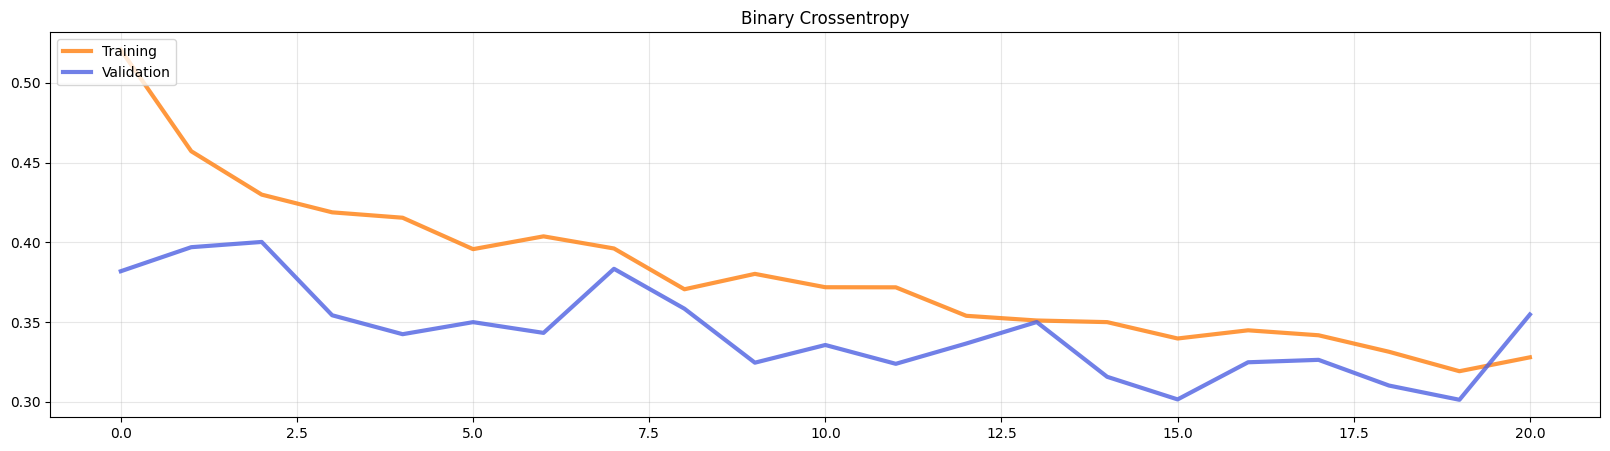

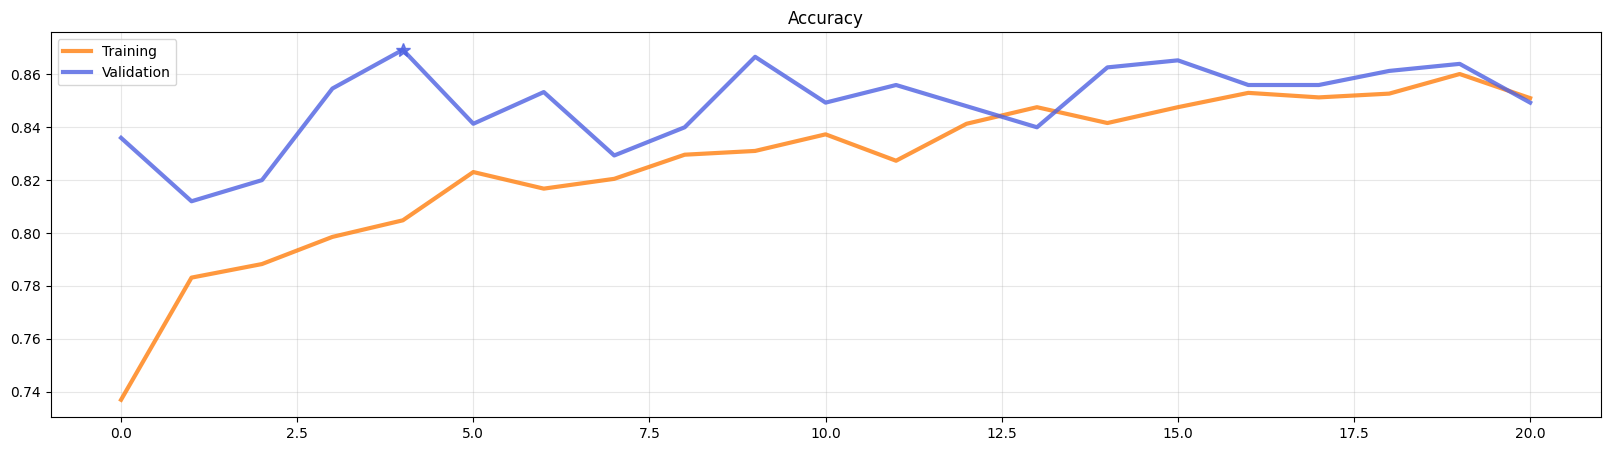

In [14]:
plot_training(tl_history)

Accuracy: 0.8373
Precision: 0.7964
Recall: 0.7684
F1: 0.7821


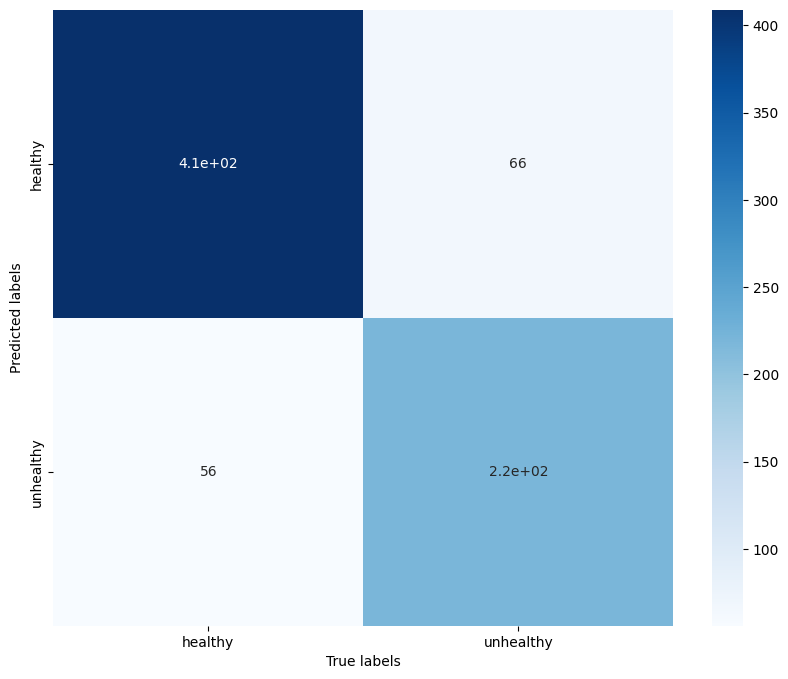

In [15]:
plot_confusion_matrix(preprocess_input(X_test*255), y_test, model_to_test=tl_model)

In [ ]:
del tl_model

##### 1 class

In [ ]:
from tensorflow.keras.applications.efficientnet import preprocess_input

In [18]:
efficient = tf.keras.applications.EfficientNetB0(
                    include_top=False,
                    weights="imagenet",
                    input_shape=(96, 96, 3),
                    pooling='avg',
                  )

efficient.trainable = False


preprocessing = tfk.Sequential([
        tfkl.RandomFlip('horizontal_and_vertical'),
        #tfkl.RandomContrast(0.3),
        #tfkl.RandomBrightness(0.0005),
        #tfkl.ZeroPadding2D((2, 2)),
        #tfkl.RandomCrop(96, 96),
        tfkl.RandomRotation(0.5),
    ], name='Preprocessing')

classifier = tfk.Sequential([
      #tfkl.Dense(64, activation='relu'),
      #tfkl.Dropout(0.5),
      #tfkl.Dense(32, activation='relu'),
      #tfkl.Dropout(0.5),
      tfkl.Dense(256, activation='relu', kernel_initializer=tfk.initializers.HeUniform()),#4096
      tfkl.Dropout(0.5),
      tfkl.Dense(128, activation='relu', kernel_initializer=tfk.initializers.HeUniform()),#1024
      tfkl.Dropout(0.5),
      tfkl.Dense(1, activation='sigmoid')
], name='Classifier')

# Create an input layer with shape (96, 96, 3)
inputs = tfk.Input(shape=(96, 96, 3))

# Data augmentation
augmentation = preprocessing(inputs)

# Connect MobileNetV2 to the input
x = efficient(augmentation)

outputs = classifier(x)

tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

#tl_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
tl_model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

tl_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 Preprocessing (Sequential)  (None, 96, 96, 3)         0         
                                                                 
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 Classifier (Sequential)     (None, 1)                 360961    
                                                                 
Total params: 4410532 (16.82 MB)
Trainable params: 360961 (1.38 MB)
Non-trainable params: 4049571 (15.45 MB)
_________________________________________________________________


In [19]:
# Define callbacks
early_stopping = tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=15, mode='max', restore_best_weights=True)
lr_scheduler = tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=5, factor=0.999, mode='max', min_lr=1e-5)


# Train the model
tl_history = tl_model.fit(
    x = preprocess_input(X_train*255),
    y = y_train,
    batch_size = 16,
    epochs = 100,
    class_weight={0: 0.806869961444094, 1: 1.3146773272415762},
    validation_data = (preprocess_input(X_val*255), y_val),
    callbacks = [early_stopping, lr_scheduler]
).history

Epoch 1/100
219/219 [==============================] - 17s 47ms/step - loss: 0.7092 - accuracy: 0.5537 - val_loss: 0.6050 - val_accuracy: 0.6973 - lr: 1.0000e-04
Epoch 2/100
219/219 [==============================] - 3s 15ms/step - loss: 0.6238 - accuracy: 0.6447 - val_loss: 0.5069 - val_accuracy: 0.7787 - lr: 1.0000e-04
Epoch 3/100
219/219 [==============================] - 3s 15ms/step - loss: 0.5761 - accuracy: 0.6886 - val_loss: 0.4630 - val_accuracy: 0.7840 - lr: 1.0000e-04
Epoch 4/100
219/219 [==============================] - 4s 18ms/step - loss: 0.5501 - accuracy: 0.7138 - val_loss: 0.4226 - val_accuracy: 0.8187 - lr: 1.0000e-04
Epoch 5/100
219/219 [==============================] - 3s 16ms/step - loss: 0.5305 - accuracy: 0.7363 - val_loss: 0.4104 - val_accuracy: 0.8080 - lr: 1.0000e-04
Epoch 6/100
219/219 [==============================] - 4s 18ms/step - loss: 0.5151 - accuracy: 0.7469 - val_loss: 0.4052 - val_accuracy: 0.8240 - lr: 1.0000e-04
Epoch 7/100
219/219 [============

In [20]:
tl_model.save('models/transfer_learning_efficientnetb0_0_sig')

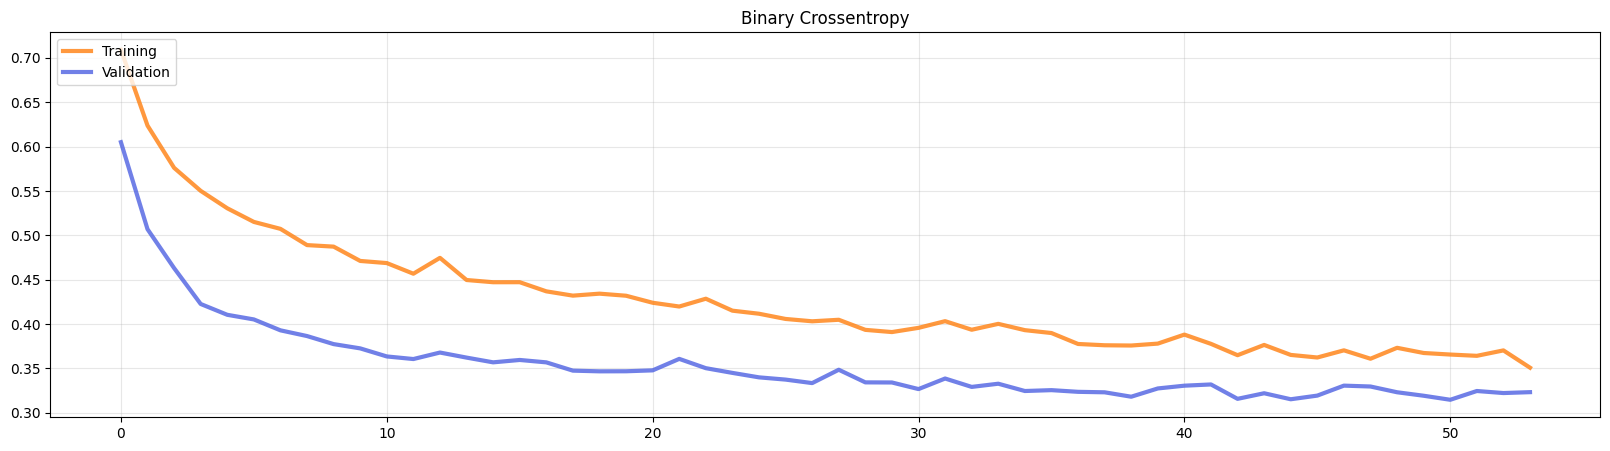

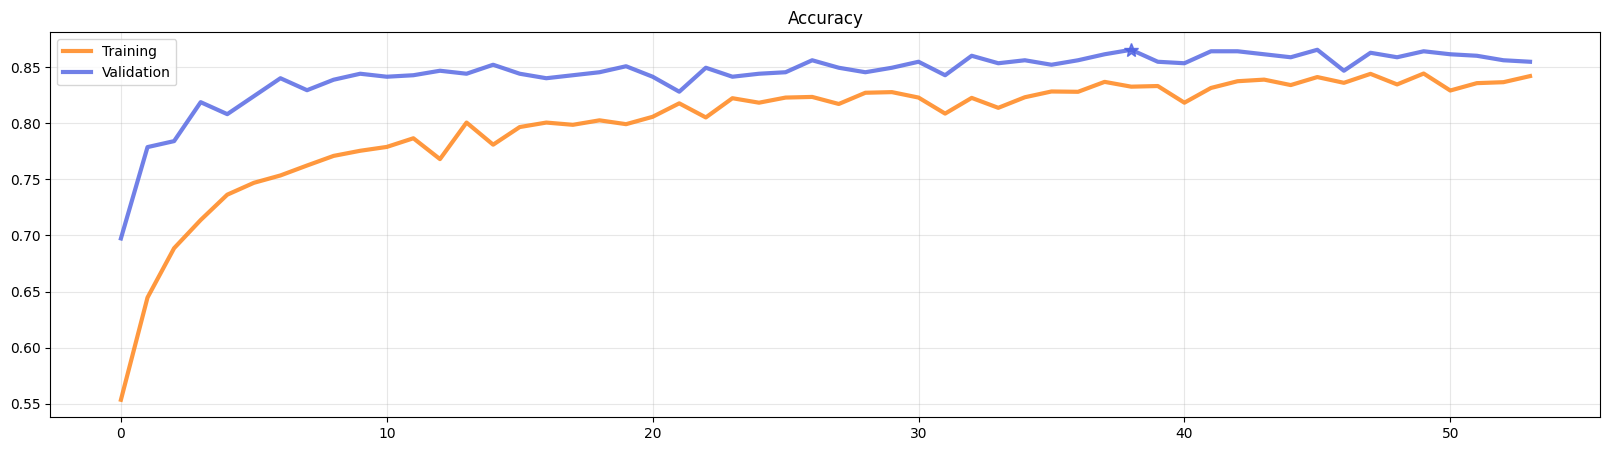

In [21]:
plot_training(tl_history)

Accuracy: 0.8493
Precision: 0.8525
Recall: 0.7298
F1: 0.7864


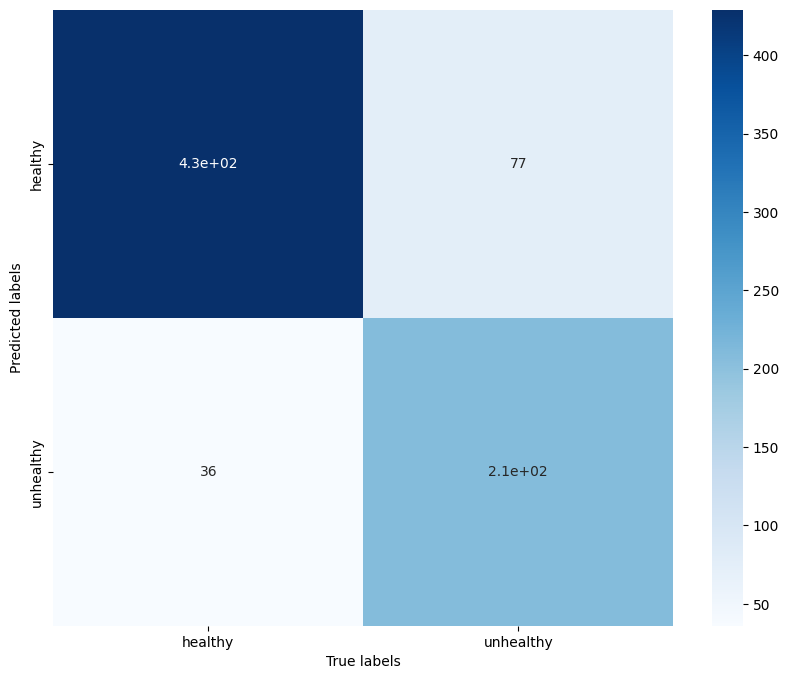

In [26]:
plot_confusion_matrix(preprocess_input(X_test*255), y_test, model_to_test=tl_model, one_class=True)

In [27]:
del tl_model

#### Fine tuning

In [ ]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model('models/transfer_learning_efficientnetb0_4_sig')
ft_model.summary()

In [ ]:
# Set all MobileNetV2 layers as trainable
ft_model.get_layer('efficientnetb0').trainable = True
for i, layer in enumerate(ft_model.get_layer('efficientnetb0').layers):
   print(i, layer.name, layer.trainable)

In [ ]:
# Freeze first N layers, e.g., until the 133rd one
N = 222
for i, layer in enumerate(ft_model.get_layer('efficientnetb0').layers[:N]):
  layer.trainable=False
#for i, layer in enumerate(ft_model.get_layer('efficientnetb0').layers[207:]):
#  layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('efficientnetb0').layers[N:]):
  if 'bn' in layer.name:
    layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('efficientnetb0').layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()

In [ ]:
# Compile the model
ft_model.compile(loss=tfk.losses.BinaryCrossentropy(), optimizer=tfk.optimizers.AdamW(1e-5), metrics='accuracy')

In [ ]:
early_stopping = tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=15, mode='max', restore_best_weights=True)
lr_scheduler = tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=3, factor=0.999, mode='max', min_lr=1e-7)

# Fine-tune the model
ft_history = ft_model.fit(
    x = preprocess_input(new_X*255), # We need to apply the preprocessing thought for the MobileNetV2 network
    y = new_y,
    batch_size = 16,
    epochs = 200,
    validation_data = (preprocess_input(X_val*255), y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = [early_stopping, lr_scheduler]
).history

In [ ]:
ft_model.save('models/ft_efficientnetb0_4_sig')

In [ ]:
del ft_model

In [ ]:
plot_confusion_matrix_sigmoid('models/ft_efficientnetb0_4_sig', preprocess_input(X_test*255), y_test)

### 2.4 Enrico's models

## 3. Results and conclusions



In [ ]:
# Find the epoch with the highest validation accuracy
best_epoch = np.argmax(history['val_accuracy'])

# Plot training and validation performance metrics
plt.figure(figsize=(20, 5))

# Plot training and validation loss
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=0.3)

plt.figure(figsize=(20, 5))

# Plot training and validation accuracy, highlighting the best epoch
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.plot(best_epoch, history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=0.3)

plt.show()

# There is no overfitting -> good!

In [ ]:
pred = model.predict(np.expand_dims(images[0], axis=0), verbose=0)
pred, labels[0]

(array([[0.67947716, 0.32052287]], dtype=float32), 'healthy')

## Train MobileNetV2 from scratch

In [ ]:
# Create MobileNetV2 model with specified settings
mobile = tfk.applications.MobileNetV2(
    input_shape=(96, 96, 3),
    include_top=False,  # We avoid to include the fully connected layers that
                        # are designed for a 1000-classes classification.
    weights=None,       # We will not download the trained weights, we'll have
                        # only the network (we train from skratch).
    pooling='avg',      # Type of pooling.
)

# Display the model architecture with input shapes
tfk.utils.plot_model(mobile, show_shapes=True)

# DepthwiseConv2D is another different type of layer.

# There are skip connections. The most important information are at the lowest
# levels, in sequential networks I can extract information from the last layer,
# adding skip connections, I'm able to exploit information form the both the
# initial and final levels.

# Using skip connections, I need to merge the information coming from different
# layers in the correct way: in case of concatenation, I have to concatenate
# kernels, in case of addition, I have need to have exactly the same shape of
# the activations.

In [ ]:
# Create an input layer with shape (96, 96, 3)
inputs = tfk.Input(shape=(96, 96, 3))
# Connect MobileNetV2 to the input
x = mobile(inputs)
# Add a Dense layer with 2 units and softmax activation as the classifier
outputs = tfkl.Dense(2, activation='softmax')(x)

# Create a Model connecting input and output
model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with Categorical Cross-Entropy loss and Adam optimizer
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

# Display model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 mobilenetv2_1.00_96 (Funct  (None, 1280)              2257984   
 ional)                                                          
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 2226434 (8.49 MB)
Non-trainable params: 34112 (133.25 KB)
_________________________________________________________________


In [ ]:
# Train the model
history = model.fit(
    x = preprocess_input(X_train*255), # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (preprocess_input(X_val*255), y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

# Here we are training from skretch the network (this is not transfer learning).
# We are overfitting a lot, the network is completely unable to generalise.
# We can see that the accuracy on the training set is almost 100% and the
# accuracy on the validation set is 50% (random guess).
# The network is not able to generalise since training such a big network is not
# easy and needs some steps to do and some particular techniques. Moreover here
# we have a too small input dataset.

# To train big networks we need to apply particular pipelines of learning rates,
# we need to apply warmup (training using small learning rates).

In [ ]:
# Plot the re-trained MobileNetV2 training history
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Re-trained', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Re-trained', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

## Transfer Learning
Leveraging pre-trained network for a different classification problem

In [ ]:
mobile = tfk.applications.MobileNetV2(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
)
tfk.utils.plot_model(mobile, show_shapes=True)

# Transfer learning: we want to freeze the parameters of the feature extraction
# network and we want to train the classification head (fully connected NN).

In [ ]:
# Use the supernet as feature extractor, i.e. freeze all its weigths
mobile.trainable = False

# Create an input layer with shape (224, 224, 3)
inputs = tfk.Input(shape=(96, 96, 3))
# Connect MobileNetV2 to the input
x = mobile(inputs)
# Add a Dense layer with 2 units and softmax activation as the classifier
outputs = tfkl.Dense(2, activation='softmax')(x)

# Create a Model connecting input and output
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with Categorical Cross-Entropy loss and Adam optimizer
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

# Display model summary
tl_model.summary()

In [ ]:
# Train the model
tl_history = tl_model.fit(
    x = preprocess_input(X_train*255), # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (preprocess_input(X_val*255), y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
).history

In [ ]:
# Evaluate the model on the test set
test_accuracy = tl_model.evaluate(preprocess_input(X_test*255),y_test,verbose=0)[-1]
print('Test set accuracy %.4f' % test_accuracy)

Test set accuracy 0.8300


In [ ]:
# Plot the re-trained and the transfer learning MobileNetV2 training histories
plt.figure(figsize=(15,5))
#plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
#plt.plot(history['val_loss'], label='Re-trained', alpha=.8, color='#ff7f0e')
plt.plot(tl_history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
#plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
#plt.plot(history['val_accuracy'], label='Re-trained', alpha=.8, color='#ff7f0e')
plt.plot(tl_history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

# We achieved the performance of the network we designed in a small number of
# epochs.

Predictions Shape: (100, 2)
Accuracy: 0.83
Precision: 0.827
Recall: 0.8069
F1: 0.8144


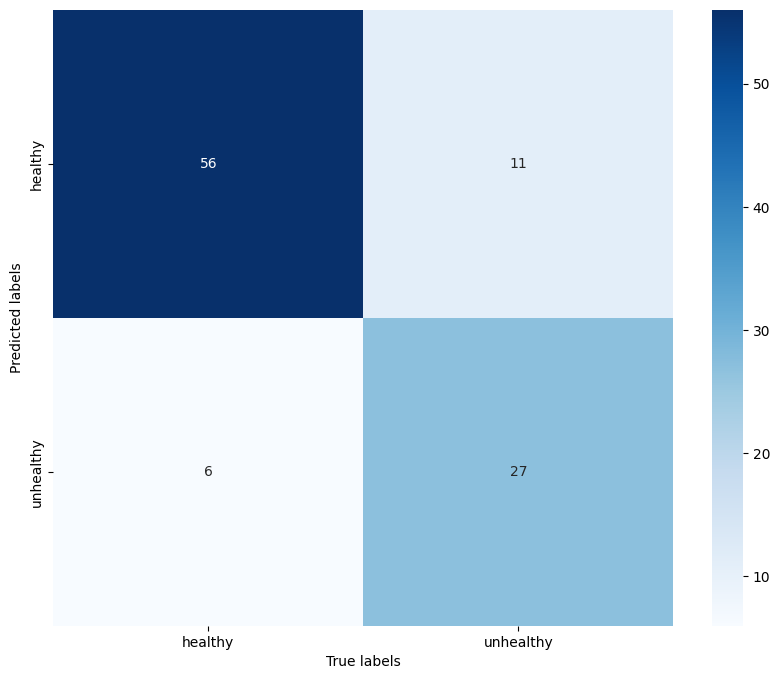

In [ ]:
# Predict labels for the entire test set
predictions = tl_model.predict(preprocess_input(X_test*255), verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list(('healthy','unhealthy')), yticklabels=list(('healthy','unhealthy')), cmap='Blues', annot=True)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

# Still good performances

In [ ]:
# Save the best model
tl_model.save('TransferLearningModel_2')
#del tl_model

In [ ]:
m = tf.keras.models.load_model('trial')

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.applications.mobilenet import preprocess_input

class model:
    def __init__(self, path):
        self.model = tf.keras.models.load_model( 'trial')

    def predict(self, X):

        # Note: this is just an example.
        # Here the model.predict is called, followed by the argmax
        out = self.model.predict(preprocess_input(X*255))
        out = tf.argmax(out, axis=-1)  # Shape [BS]

        return out

In [ ]:
model = model(os.getcwd())
pred = model.predict(X_test)
pred

2/2 [==============================] - 1s 29ms/step


<tf.Tensor: shape=(60,), dtype=int64, numpy=
array([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0])>

In [ ]:
np.argmax(predictions, axis=-1)

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0])

## Fine Tuning
Training also the backbone network. To this purpose it is better to
1.   Perform transfer learning, namely train the new classification head only;
2.   Unfreeze the backbone layers (or possibly a few of them depending on the amount of training data) and train the entire netrwork. Note that the classification head needs to be a properly trained model. We adjust the last set of transformations, we use a very small learning rate.

Training a neural network cannot be done end-to-end. Most effective trainings are split in many steps.



In [ ]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model('TransferLearningModel_1')
ft_model.summary()

In [ ]:
# Set all MobileNetV2 layers as trainable
ft_model.get_layer('mobilenetv2_1.00_96').trainable = True
for i, layer in enumerate(ft_model.get_layer('mobilenetv2_1.00_96').layers):
   print(i, layer.name, layer.trainable)

# I can also iteratively unfreeze only some parts of the network and do the
# training, e.g. the first time, only the last layer; the second time, only the
# last two, and so on.
# We can also unfreeze different parts of the networks in different steps of the
# training keeping freezed the others, training alternatively different parts of
# the network. We can change the learning rates training different parts (e.g.
# higher learning rates on the last layers and smaller learning rates in the
# case of the training of the CNN layers).

In [ ]:
# Freeze first N layers, e.g., until the 133rd one
N = 133
for i, layer in enumerate(ft_model.get_layer('mobilenetv2_1.00_96').layers[:N]):
  layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('mobilenetv2_1.00_96').layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()

0 input_3 False
1 Conv1 False
2 bn_Conv1 False
3 Conv1_relu False
4 expanded_conv_depthwise False
5 expanded_conv_depthwise_BN False
6 expanded_conv_depthwise_relu False
7 expanded_conv_project False
8 expanded_conv_project_BN False
9 block_1_expand False
10 block_1_expand_BN False
11 block_1_expand_relu False
12 block_1_pad False
13 block_1_depthwise False
14 block_1_depthwise_BN False
15 block_1_depthwise_relu False
16 block_1_project False
17 block_1_project_BN False
18 block_2_expand False
19 block_2_expand_BN False
20 block_2_expand_relu False
21 block_2_depthwise False
22 block_2_depthwise_BN False
23 block_2_depthwise_relu False
24 block_2_project False
25 block_2_project_BN False
26 block_2_add False
27 block_3_expand False
28 block_3_expand_BN False
29 block_3_expand_relu False
30 block_3_pad False
31 block_3_depthwise False
32 block_3_depthwise_BN False
33 block_3_depthwise_relu False
34 block_3_project False
35 block_3_project_BN False
36 block_4_expand False
37 block_4_expa

In [ ]:
# Compile the model
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-5), metrics='accuracy')

In [ ]:
# Fine-tune the model
ft_history = ft_model.fit(
    x = preprocess_input(X_train*255), # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (preprocess_input(X_val*255), y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

# The first epoch is already more performing than all the previous model we have
# created.

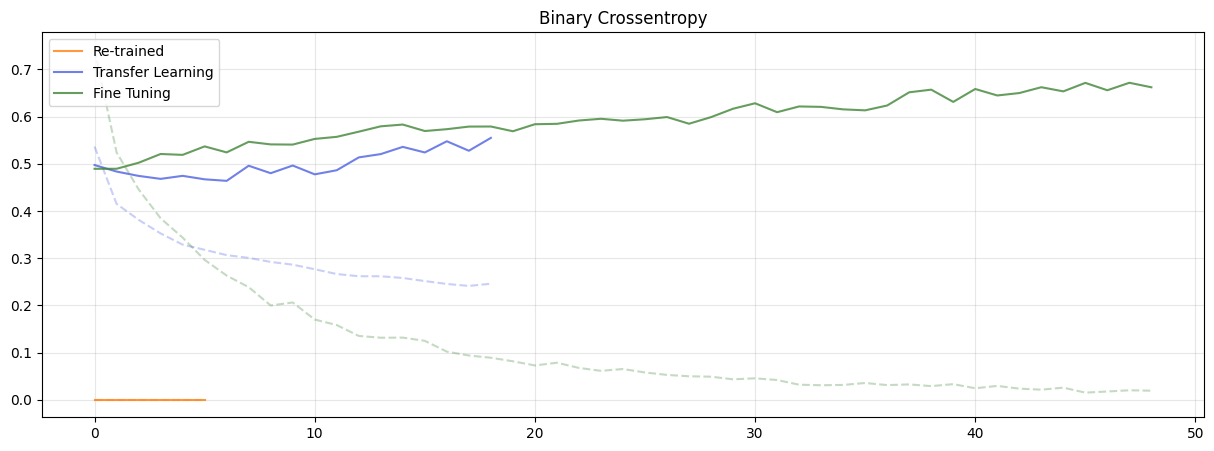

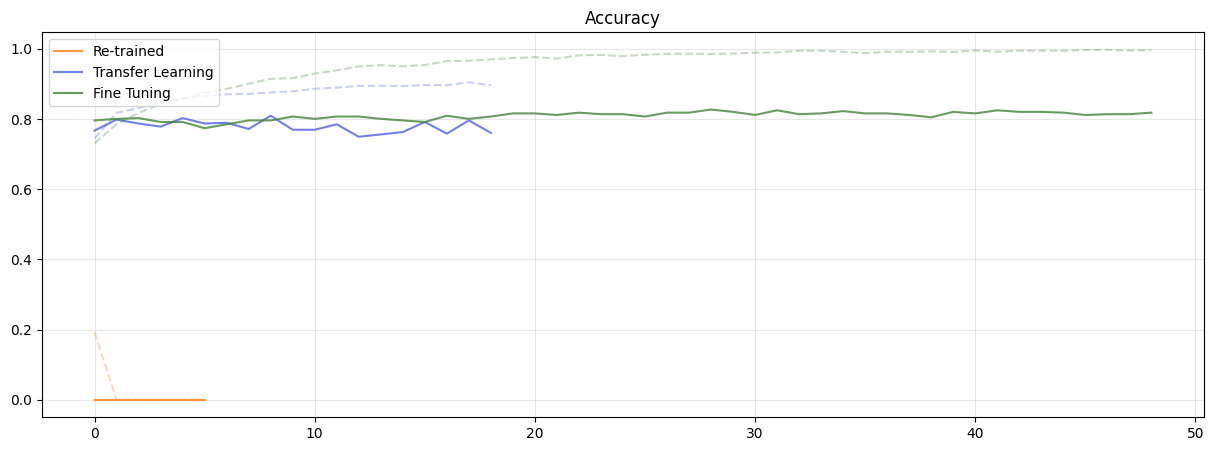

In [ ]:
# Plot the re-trained, the transfer learning and the fine-tuned MobileNetV2 training histories
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Re-trained', alpha=.8, color='#ff7f0e')
plt.plot(tl_history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.plot(ft_history['loss'], alpha=.3, color='#408537', linestyle='--')
plt.plot(ft_history['val_loss'], label='Fine Tuning', alpha=.8, color='#408537')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Re-trained', alpha=.8, color='#ff7f0e')
plt.plot(tl_history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.plot(ft_history['accuracy'], alpha=.3, color='#408537', linestyle='--')
plt.plot(ft_history['val_accuracy'], label='Fine Tuning', alpha=.8, color='#408537')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

# We can also skip the transfer learning step but it will be more difficult for
# the network to learn.

In [ ]:
# Evaluate the model on the test set
test_accuracy = ft_model.evaluate(preprocess_input(X_test*255),y_test,verbose=0)[-1]
print('Test set accuracy %.4f' % test_accuracy)

# Very good performance on the test set.

[0.7159918546676636, 0.7884231805801392]

[[1.0211155e-04 9.9989784e-01]
 [9.9999988e-01 8.9594650e-08]
 [9.4073421e-01 5.9265766e-02]
 ...
 [8.8477479e-03 9.9115223e-01]
 [9.9960095e-01 3.9906698e-04]
 [5.7495506e-03 9.9425042e-01]]
[1 0 0 0 0 0 0 0 1 0 1 1 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 1 1
 1 1 0 0 1 1 0 0 1 1 0 0 0 0 1 0 1 0 0 1 0 1 0 0 0 0 0 0 1 1 0 1 1 0 1 0 0
 0 0 0 0 0 1 0 1 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 0 1 1 1 0 1 0 1 0 0 0 0 0 1
 1 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 1 0 1 0 1 1 1 0
 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 1
 1 1 0 0 0 0 0 1 1 0 1 1 0 0 0 0 1 1 0 1 0 1 1 0 0 1 1 0 0 1 1 1 0 0 0 0 1
 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 1 1 0 1 1
 0 0 0 0 1 1 1 1 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 1 1 1 1 1 1
 0 1 0 1 1 0 0 1 0 0 0 0 1 1 0 1 0 0 0 0 1 0 0 1 0 0 0 1 0 1 1 1 1 1 1 1 0
 1 1 0 0 0 1 1 0 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0
 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1 1 1 0 0 0 0 1

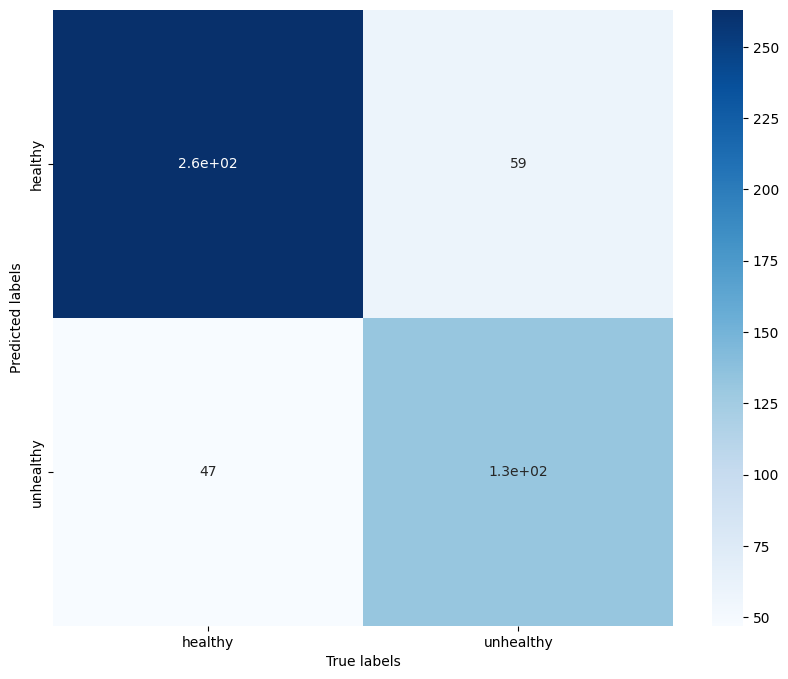

In [ ]:
# Predict labels for the entire test set
predictions = ft_model.predict(preprocess_input(X_test*255), verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))

# Compute classification metrics
accuracy = accuracy_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_test, axis=-1), np.argmax(predictions, axis=-1), average='macro')

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, xticklabels=list(('healthy','unhealthy')), yticklabels=list(('healthy','unhealthy')), cmap='Blues', annot=True)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

# Still good performances

In [ ]:
# Save the best model
ft_model.save('FineTuningModel')
del ft_model

### Test on your own data

In [ ]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model('FineTuningModel')
ft_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 dense_1 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 1208642 (4.61 MB)
Non-trainable params: 1051904 (4.01 MB)
_________________________________________________________________


In [ ]:
test_path = 'test_images/'
test = load_images_from_folder(test_path)
test.shape

(4, 224, 224, 3)

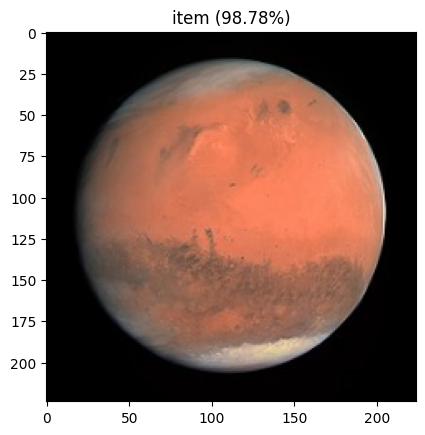

In [ ]:
# predict the test image
test_predictions = ft_model.predict(preprocess_input(test*255), verbose=0)

index = 2
prediction = test_predictions[index]

if prediction[0] >= prediction[1]:
    label = 'item'
    probability = float("{:.{}f}".format(prediction[0], 4))*100

else:
    label = 'animal'
    probability = float("{:.{}f}".format(prediction[1], 4))*100

plt.title(f'{label} ({probability}%)')
plt.imshow(np.squeeze(test[index]))
plt.show()

### TODO Exercise
Practice the various transformations, create your own successful preprocessing pipeline and compare different Keras applications' architectures.

What happens if you combine augmentation techniques with fine tuning?

*Credits: Eugenio Lomurno, 📧 eugenio.lomurno@polimi.it*